**Imports** 🕵️‍♂️

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense, Dropout, LSTM
from keras.models import Sequential
from keras.optimizers import Adam
from scipy.signal import detrend
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score

**Functions** 🤌

In [84]:
def preprocess_data(feature_names):
    # Load the data
    df = pd.read_csv('../../../data/kc/btc/heiken_ashi/with_trade_indicators/raw/kc_btc_15min_ha_ti.csv')

    # Convert color to 0 for 'red' and 1 for 'green'
    df['color'] = df['color'].map({'red': 0, 'green': 1})

    # Add 'color_change' column: 1 if color changes from the previous row, 0 otherwise
    df['color_change'] = df['color'].diff().abs()

    # Fill the first row's 'color_change' with 0
    df['color_change'].fillna(0, inplace=True)

    # Drop 'time' and 'turnover' columns
    df = df.drop(['time'], axis=1)

    # Drop features
    df = df.drop(feature_names, axis=1)

    # Fill NaNs in specific columns with 0
    if 'PSARl_0.01_0.1' in df.columns:
        df['PSARl_0.01_0.1'] = df['PSARl_0.01_0.1'].fillna(0)
    if 'PSARs_0.01_0.1' in df.columns:
        df['PSARs_0.01_0.1'] = df['PSARs_0.01_0.1'].fillna(0)

    # Identify the first non-null row
    first_valid_index = df.dropna().index[0]

    # Drop the rows before this index in both features and target data
    df = df.loc[first_valid_index:]
    target = df['color_change'].loc[first_valid_index:]

    # Use ffill to fill any remaining missing values
    df.ffill(inplace=True)

    # Separate features and target
    features_df = df.drop('color_change', axis=1)

    # Determine the split point
    split_point = int(len(features_df) * 0.8)

    # Split the data into train and test sets
    X_train_df, X_test_df = features_df[:split_point], features_df[split_point:]
    y_train, y_test = target[:split_point], target[split_point:]

    # Initialize a scaler
    scaler = MinMaxScaler()

    # Scale the data
    X_train = scaler.fit_transform(X_train_df)
    X_test = scaler.transform(X_test_df)

    # Keep the column names for later use
    feature_names = X_train_df.columns.tolist()

    # Reshape the data for LSTM 
    X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    return X_train, X_test, X_train_lstm, X_test_lstm, y_train, y_test, feature_names




**Globals** 🌎

In [90]:
# # Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

feature_names = [
    # Fundamental price data
    'open', 'high', 'low', 'close', 

    # Auxiliary data
    'turnover', 'color',

    # Volume-related
    'volume', 'avg_vol_last_100', 'obv', 

    # Momentum and trend indicators
    'RSI_5', 'RSI_10', 'RSI_14',
    'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'MACD_6_13_5_6_13_5', 'MACDh_6_13_5_6_13_5', 'MACDs_6_13_5_6_13_5', 

    # Moving averages
    'SMA_20', 'SMA_5', 'SMA_10', 'EMA_2', 'EMA_5', 'EMA_10', 

    # Bollinger Bands
    'BBP_10_2.0_10', 'BBL_15_2.0_15', 'BBM_15_2.0_15', 'BBU_15_2.0_15', 'BBB_15_2.0_15', 'BBP_15_2.0_15', 'BBL_20_2.0_20', 'BBM_20_2.0_20', 'BBU_20_2.0_20', 'BBB_20_2.0_20', 'BBP_20_2.0_20', 'bollinger_bandwidth',
    'BBL_5_2.0_5', 'BBM_5_2.0_5', 'BBU_5_2.0_5', 'BBB_5_2.0_5', 'BBP_5_2.0_5', 'BBL_10_2.0_10', 'BBM_10_2.0_10', 'BBU_10_2.0_10', 'BBB_10_2.0_10', 'BBP_10_2.0_10',

    # Stochastic Oscillator
    'STOCHd_14_3_3', 'STOCHk_14_3_3_7_3_3', 'STOCHd_14_3_3_7_3_3', 'STOCHk_14_3_3_10_3_3', 'STOCHd_14_3_3_10_3_3', 

    # Volatility
    'ATR_14', 'ATR_10', 'ATR_5', 

    # Other momentum oscillators
    'ROC_14', 'ROC_10', 'ROC_5', 

    # Other versatile indicators
    'CCI_14', 'CCI_10', 'CCI_5', 

    # Money Flow Index and Chaikin Money Flow
    'cmf', 'mfi',
    
    # Relative Vigor Index (RVI)
    'RVI_15', 'RVI_10', 'RVI_5',
    
    # Pivot Points
    'PP', 'R1', 'S1', 'R2', 'S2', 'R3', 'S3',

    # Parabolic SAR (PSAR)
    'PSARl_0.01_0.1', 'PSARs_0.01_0.1',
    'PSARaf_0.01_0.1', 'PSARr_0.01_0.1',

    # Triple Exponential Average (TRIX)
    'TRIX_18_9', 'TRIXs_18_9', 'TRIX_12_6', 'TRIXs_12_6', 'TRIX_10_5', 'TRIXs_10_5',

    # Ichimoku Cloud (ISA, ISB, ITS, IKS, ICS)
    'ISA_5', 'ISB_15', 'ITS_5', 'IKS_15', 'ICS_15',

]

# Create a list of the features to be dropped
# drop_features = ['MACDs_12_26_9', 'EMA_5', 'RVI_10', 'ISA_5', 'SMA_20', 'S2', 'BBM_10_2.0_10', 
#                     'PSARl_0.01_0.1', 'IKS_15', 'BBU_15_2.0_15', 'S1', 'PSARr_0.01_0.1', 'BBL_10_2.0_10',
#                     'ATR_10', 'SMA_10', 'STOCHd_14_3_3_10_3_3', 'ICS_15', 'BBL_20_2.0_20', 'bollinger_bandwidth',
#                     'BBL_5_2.0_5', 'PP', 'TRIX_12_6', 'volume']

# Create a list of the features to be dropped
drop_features = ['MACDs_12_26_9', 'EMA_5', 'RVI_10', 'ISA_5', 'SMA_20', 'S2', 'BBM_10_2.0_10', 
                 'PSARl_0.01_0.1', 'IKS_15', 'BBU_15_2.0_15', 'S1', 'PSARr_0.01_0.1', 'BBL_10_2.0_10',
                 'ATR_10', 'SMA_10', 'STOCHd_14_3_3_10_3_3', 'ICS_15', 'BBL_20_2.0_20', 'bollinger_bandwidth',
                 'BBL_5_2.0_5', 'PP', 'TRIX_12_6', 'volume', 'BBU_20_2.0_20', 'S3', 'R3', 'BBU_5_2.0_5',
                 'BBL_15_2.0_15', 'low', 'R1', 'BBU_10_2.0_10', 'close', 'BBM_15_2.0_15', 'R2', 'BBM_20_2.0_20',
                 'high', 'ISB_15', 'BBM_5_2.0_5', 'EMA_2', 'SMA_5', 'open', 'PSARs_0.01_0.1', 'ITS_5', 
                 'EMA_10', 'PSARaf_0.01_0.1']


**Feature Engineering** 🚂

**Feature Importance** ✈️

In [87]:
# For RandomForest
X_train_rf, X_test_rf, _, _, y_train, y_test, feature_names = preprocess_data(drop_features)

# Train a random forest classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train_rf, y_train)

# Get feature importances
importances = rfc.feature_importances_

# Create a dataframe of features and their importances
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the dataframe by importance
feature_importances_df.sort_values(by='Importance', ascending=False, inplace=True)

# Display the dataframe
print(feature_importances_df)


                 Feature  Importance
42           BBP_5_2.0_5    0.072096
5                  color    0.071749
21                 CCI_5    0.055361
45         BBP_10_2.0_10    0.028397
26                 RVI_5    0.025605
11                 RSI_5    0.023569
20                CCI_10    0.023536
41           BBB_5_2.0_5    0.023118
4               turnover    0.023045
22                   cmf    0.019609
49         BBP_15_2.0_15    0.019230
19                CCI_14    0.018729
18                 ROC_5    0.018546
25                RVI_15    0.018286
53         BBP_20_2.0_20    0.017414
60         STOCHd_14_3_3    0.017240
6       avg_vol_last_100    0.016387
44         BBB_10_2.0_10    0.016080
57   MACDh_6_13_5_6_13_5    0.016066
24                   mfi    0.015679
62   STOCHd_14_3_3_7_3_3    0.015361
17                ROC_10    0.015159
12                RSI_10    0.015092
15                 ATR_5    0.015053
59         STOCHk_14_3_3    0.014896
48         BBB_15_2.0_15    0.014751
5

**Cross Validation** 🏴‍☠️

**LSTM Model** 🛰️

In [91]:
# For LSTM
_, _, X_train_lstm, X_test_lstm, y_train, y_test, _ = preprocess_data(drop_features)


# Initialize the model
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history = lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=72, 
                         validation_data=(X_test_lstm, y_test), verbose=2, shuffle=False)

# Predict class labels for the test set
y_pred_lstm = (lstm_model.predict(X_test_lstm) > 0.5).astype("int32")



Epoch 1/10
90/90 - 1s - loss: 0.6902 - accuracy: 0.5335 - val_loss: 0.6878 - val_accuracy: 0.5812 - 1s/epoch - 15ms/step
Epoch 2/10
90/90 - 0s - loss: 0.6849 - accuracy: 0.5602 - val_loss: 0.6844 - val_accuracy: 0.5893 - 174ms/epoch - 2ms/step
Epoch 3/10
90/90 - 0s - loss: 0.6756 - accuracy: 0.5897 - val_loss: 0.6767 - val_accuracy: 0.6254 - 170ms/epoch - 2ms/step
Epoch 4/10
90/90 - 0s - loss: 0.6559 - accuracy: 0.6407 - val_loss: 0.6633 - val_accuracy: 0.6341 - 169ms/epoch - 2ms/step
Epoch 5/10
90/90 - 0s - loss: 0.6231 - accuracy: 0.6985 - val_loss: 0.6365 - val_accuracy: 0.6789 - 170ms/epoch - 2ms/step
Epoch 6/10
90/90 - 0s - loss: 0.5838 - accuracy: 0.7310 - val_loss: 0.6016 - val_accuracy: 0.7100 - 167ms/epoch - 2ms/step
Epoch 7/10
90/90 - 0s - loss: 0.5510 - accuracy: 0.7432 - val_loss: 0.5768 - val_accuracy: 0.7206 - 175ms/epoch - 2ms/step
Epoch 8/10
90/90 - 0s - loss: 0.5300 - accuracy: 0.7461 - val_loss: 0.5611 - val_accuracy: 0.7231 - 172ms/epoch - 2ms/step
Epoch 9/10
90/90 -

**Feature Ablation** ⌚

Epoch 1/10
90/90 - 1s - loss: 0.6904 - accuracy: 0.5396 - val_loss: 0.6877 - val_accuracy: 0.5474 - 1s/epoch - 15ms/step
Epoch 2/10
90/90 - 0s - loss: 0.6846 - accuracy: 0.5595 - val_loss: 0.6988 - val_accuracy: 0.4819 - 166ms/epoch - 2ms/step
Epoch 3/10
90/90 - 0s - loss: 0.6758 - accuracy: 0.5934 - val_loss: 0.7197 - val_accuracy: 0.4800 - 165ms/epoch - 2ms/step
Epoch 4/10
90/90 - 0s - loss: 0.6604 - accuracy: 0.6230 - val_loss: 0.7432 - val_accuracy: 0.4788 - 166ms/epoch - 2ms/step
Epoch 5/10
90/90 - 0s - loss: 0.6396 - accuracy: 0.6549 - val_loss: 0.7602 - val_accuracy: 0.4994 - 163ms/epoch - 2ms/step
Epoch 6/10
90/90 - 0s - loss: 0.6169 - accuracy: 0.6777 - val_loss: 0.7638 - val_accuracy: 0.5287 - 166ms/epoch - 2ms/step
Epoch 7/10
90/90 - 0s - loss: 0.5950 - accuracy: 0.6981 - val_loss: 0.7516 - val_accuracy: 0.5729 - 171ms/epoch - 2ms/step
Epoch 8/10
90/90 - 0s - loss: 0.5753 - accuracy: 0.7140 - val_loss: 0.7255 - val_accuracy: 0.6153 - 171ms/epoch - 2ms/step
Epoch 9/10
90/90 -

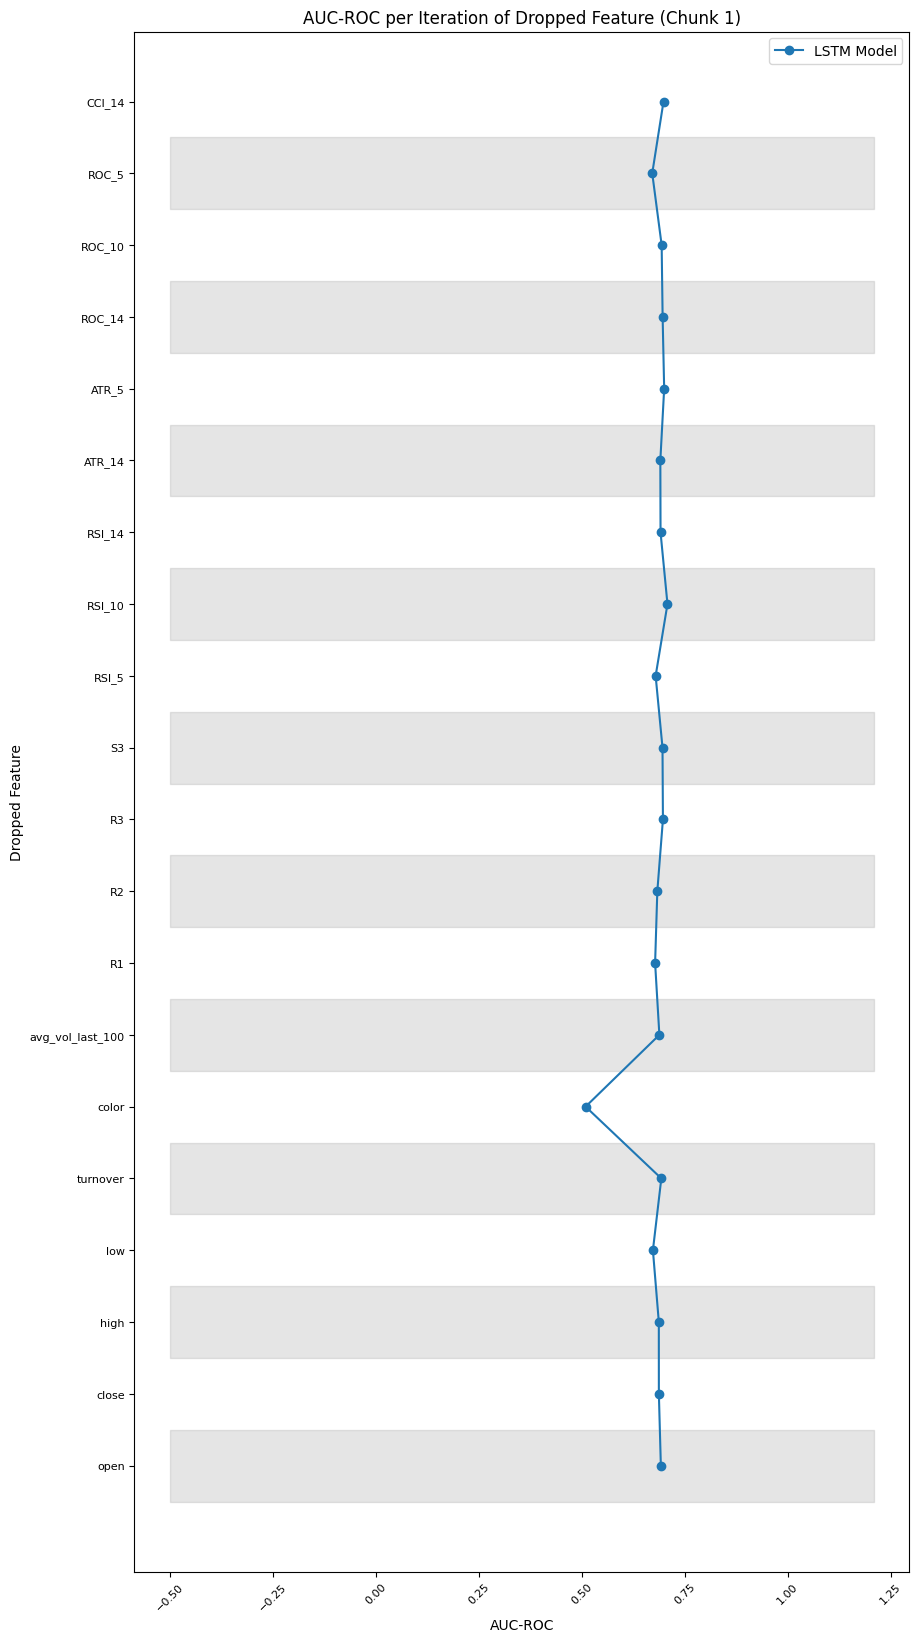

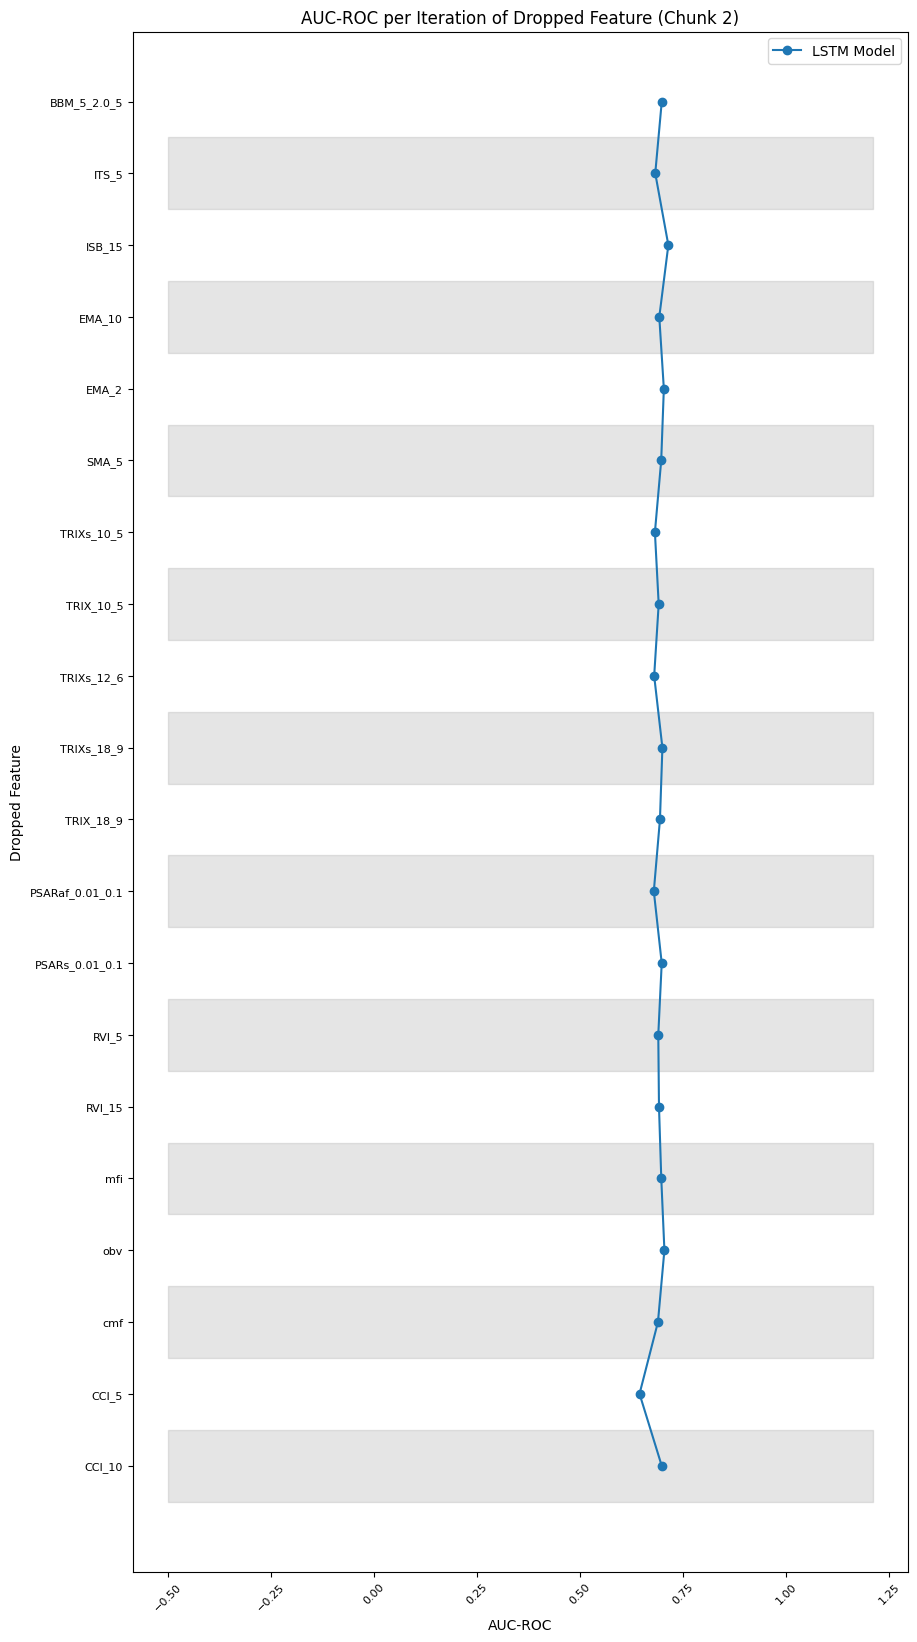

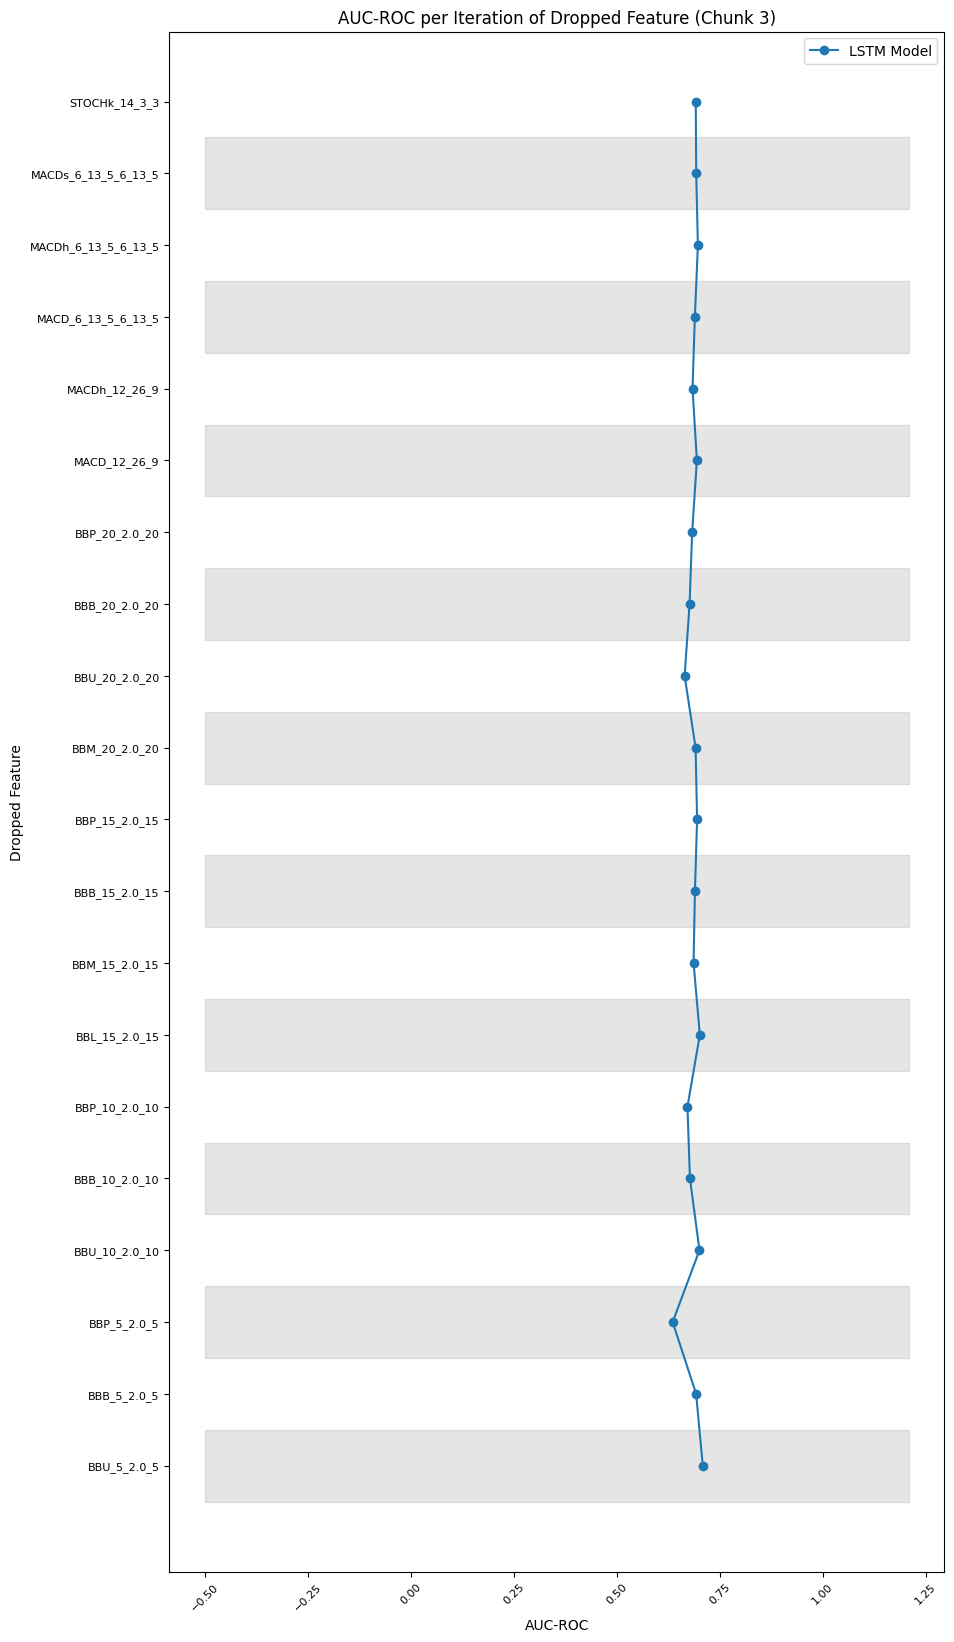

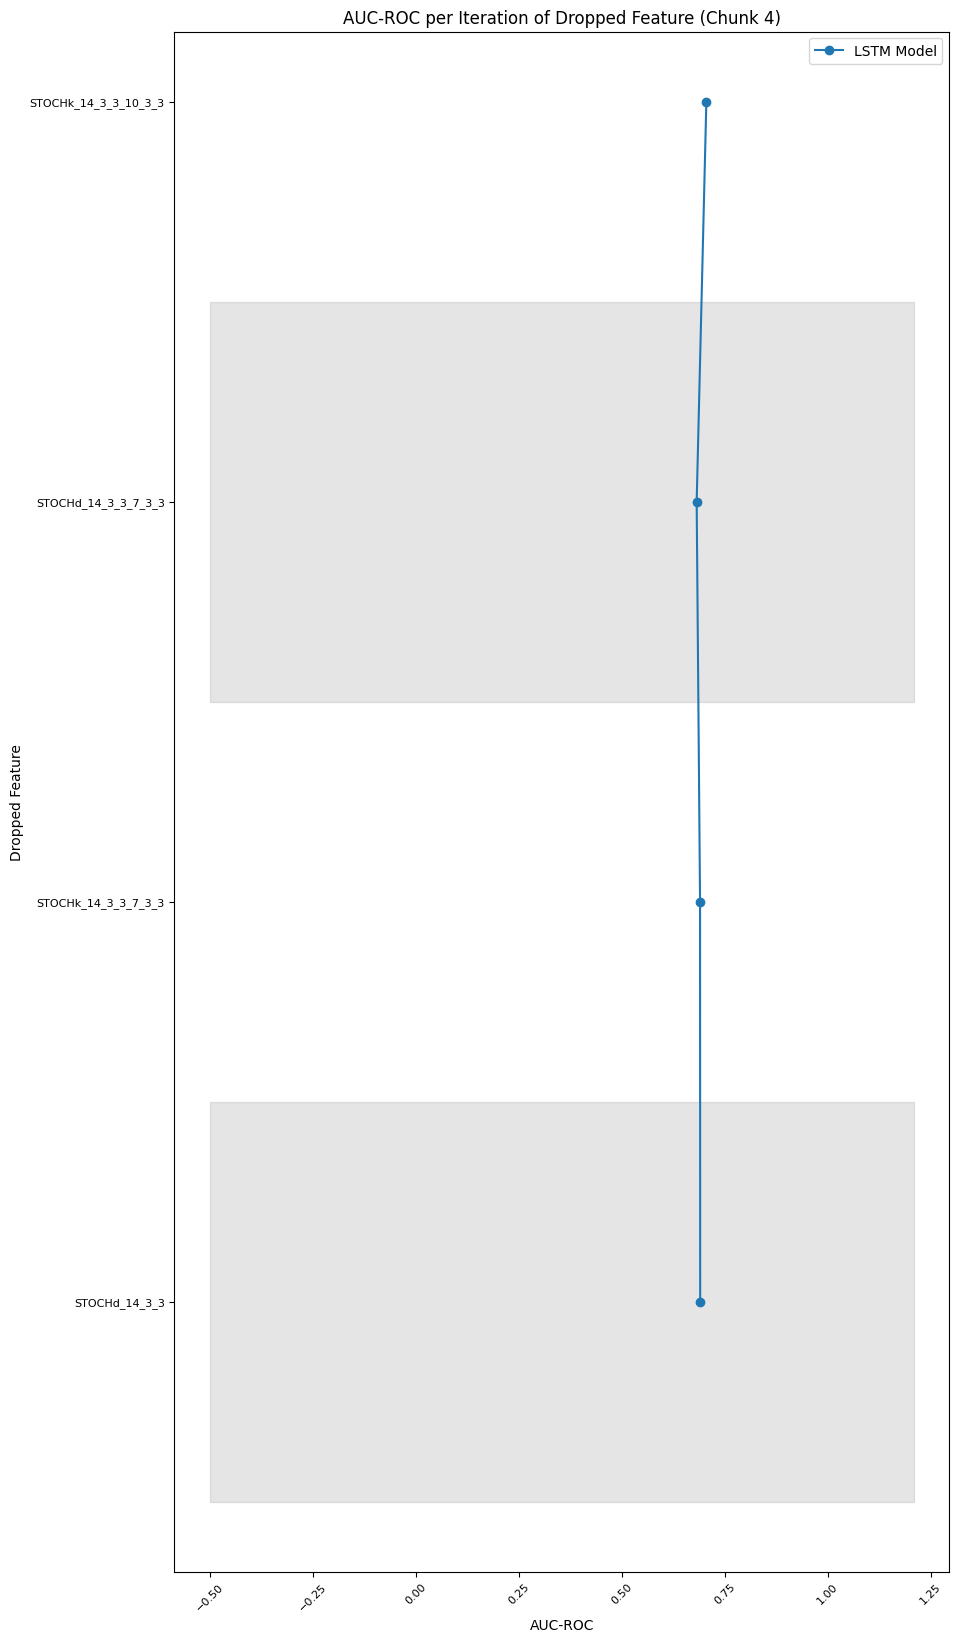

Feature: ISB_15, AUC-ROC score: 0.7141
Feature: BBU_5_2.0_5, AUC-ROC score: 0.7091
Feature: RSI_10, AUC-ROC score: 0.7083
Feature: STOCHk_14_3_3_10_3_3, AUC-ROC score: 0.7056
Feature: obv, AUC-ROC score: 0.7045
Feature: EMA_2, AUC-ROC score: 0.7031
Feature: BBL_15_2.0_15, AUC-ROC score: 0.7019
Feature: BBU_10_2.0_10, AUC-ROC score: 0.7011
Feature: ATR_5, AUC-ROC score: 0.7003
Feature: TRIXs_18_9, AUC-ROC score: 0.6996
Feature: CCI_14, AUC-ROC score: 0.6987
Feature: BBM_5_2.0_5, AUC-ROC score: 0.6981
Feature: PSARs_0.01_0.1, AUC-ROC score: 0.6980
Feature: CCI_10, AUC-ROC score: 0.6979
Feature: R3, AUC-ROC score: 0.6973
Feature: MACDh_6_13_5_6_13_5, AUC-ROC score: 0.6972
Feature: mfi, AUC-ROC score: 0.6969
Feature: SMA_5, AUC-ROC score: 0.6967
Feature: ROC_14, AUC-ROC score: 0.6965
Feature: S3, AUC-ROC score: 0.6963
Feature: BBP_15_2.0_15, AUC-ROC score: 0.6953
Feature: MACD_12_26_9, AUC-ROC score: 0.6947
Feature: ROC_10, AUC-ROC score: 0.6942
Feature: TRIX_18_9, AUC-ROC score: 0.6937
Fe

In [88]:
# Initialize a list to hold AUC-ROC scores for each iteration
auc_roc_lstm_history = []

for feature in feature_names:
    # Call your function to preprocess the data
    _, _, X_train_lstm, X_test_lstm, y_train, y_test, _ = preprocess_data([feature])

    # Initialize the LSTM model
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    lstm_model.add(Dense(1, activation='sigmoid'))

    # Compile the LSTM model
    lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Fit the LSTM model
    history = lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=72, 
                             validation_data=(X_test_lstm, y_test), verbose=2, shuffle=False)

    # Predict class labels for the test set
    y_pred_lstm = (lstm_model.predict(X_test_lstm) > 0.5).astype("int32")

    # Compute AUC-ROC for the LSTM model
    auc_roc_lstm = roc_auc_score(y_test, y_pred_lstm)

    # Add the AUC-ROC score to the list
    auc_roc_lstm_history.append(auc_roc_lstm)

# Function to divide the feature_names list into sublists of 20 features each
def divide_chunks(lst, chunk_size):
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

# Divide the feature_names list into sublists of 20 features each
chunk_size = 20
feature_names_chunks = list(divide_chunks(feature_names, chunk_size))

# Loop through the sublists and create a chart for each sublist
for chunk_index, feature_names_chunk in enumerate(feature_names_chunks):

    # Set the figure size
    plt.figure(figsize=(10, 20))  # Adjust the figure size here

    # Plot the AUC-ROC for each iteration
    plt.plot(auc_roc_lstm_history[chunk_index * chunk_size:(chunk_index + 1) * chunk_size], 
             feature_names_chunk, marker='o', label='LSTM Model')

    # Set the axes labels and title
    plt.ylabel('Dropped Feature')
    plt.xlabel('AUC-ROC')
    plt.title(f'AUC-ROC per Iteration of Dropped Feature (Chunk {chunk_index + 1})')

    # Set the x-axis ticks and labels
    plt.xticks(fontsize=8, rotation=45)

    # Set the y-axis ticks and labels
    plt.yticks(range(len(feature_names_chunk)), feature_names_chunk, fontsize=8)

    # Add colored rows for better readability
    for i in range(len(feature_names_chunk)):
        if i % 2 == 0:
            plt.fill_between(np.arange(-0.5, max(auc_roc_lstm_history) + 0.5, 0.01), 
                             i - 0.5, i + 0.5, color='gray', alpha=0.2)

    # Add the legend and display the chart
    plt.legend()
    plt.show()

# Create a dictionary of features and their corresponding AUC-ROC scores
features_auc_roc_lstm_dict = dict(zip(feature_names, auc_roc_lstm_history))

# Create a sorted list of tuples from the dictionary
sorted_features_auc_roc_lstm = sorted(features_auc_roc_lstm_dict.items(), key=lambda item: item[1], reverse=True)

# Print the sorted list
for feature, auc_roc in sorted_features_auc_roc_lstm:
    print(f'Feature: {feature}, AUC-ROC score: {auc_roc:.4f}')
